In [34]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [67]:
df = pd.read_excel('./data_set/coinmarketcap_bitcoin_data_2017.xlsx')

# ethereum
#df = pd.read_excel('./data_set/coinmarketcap_ethereum_data_2017.xlsx')

In [68]:
df.head()

,date,open,high,low,close,volume,marketcap
0,2019-12-31,7294.44,7335.29,7169.78,7193.60,21167946112,130446112598
1,2019-12-30,7420.27,7454.82,7276.31,7293.00,22874131672,132235128152
2,2019-12-29,7317.65,7513.95,7279.87,7422.65,22445257702,134570835775
3,2019-12-28,7289.03,7399.04,7286.91,7317.99,21365673026,132659059740
4,2019-12-27,7238.14,7363.53,7189.93,7290.09,22777360996,132139502950


In [69]:
df.tail()

,date,open,high,low,close,volume,marketcap
725,2018-01-05,15477.2,17705.2,15202.8,17429.5,23840899072,292544135538
726,2018-01-04,15270.7,15739.7,14522.2,15599.2,21783199744,261795321110
727,2018-01-03,14978.2,15572.8,14844.5,15201.0,16871900160,255080562912
728,2018-01-02,13625.0,15444.6,13163.6,14982.1,16846600192,251377913955
729,2018-01-01,14112.2,14112.2,13154.7,13657.2,10291200000,229119155396


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
date         730 non-null datetime64[ns]
open         730 non-null float64
high         730 non-null float64
low          730 non-null float64
close        730 non-null float64
volume       730 non-null int64
marketcap    730 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 40.0 KB


In [71]:
df = df.sort_index(ascending=0)

In [77]:
df.reset_index(inplace=True)

In [80]:
df.drop(['index'], axis = 1, inplace=True)

In [81]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.729200
1,0.821913
2,0.837232
3,0.865097
4,0.993177


In [82]:
simulation_size = 10
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01

df_train = df_log
df.shape, df_train.shape

((730, 7), (730, 1))

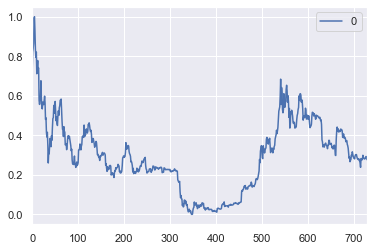

In [83]:
df_train.plot()

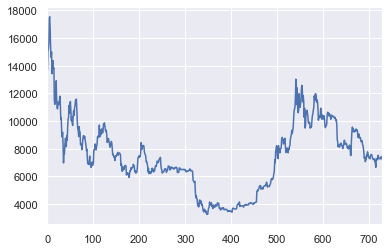

In [84]:
df.close.plot()

In [85]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [86]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [87]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|███████████████████████████████████████████| 300/300 [03:33<00:00,  1.40it/s, acc=98.2, cost=0.000817]


simulation 2


train loop: 100%|███████████████████████████████████████████| 300/300 [03:22<00:00,  1.48it/s, acc=98.3, cost=0.000756]


simulation 3


train loop: 100%|████████████████████████████████████████████| 300/300 [03:34<00:00,  1.40it/s, acc=97.7, cost=0.00146]


simulation 4


train loop: 100%|██████████████████████████████████████████████| 300/300 [02:57<00:00,  1.69it/s, acc=98, cost=0.00102]


simulation 5


train loop: 100%|███████████████████████████████████████████| 300/300 [02:57<00:00,  1.69it/s, acc=98.2, cost=0.000805]


simulation 6


train loop: 100%|████████████████████████████████████████████| 300/300 [02:57<00:00,  1.69it/s, acc=97.9, cost=0.00109]


simulation 7


train loop: 100%|████████████████████████████████████████████| 300/300 [02:47<00:00,  1.80it/s, acc=97.6, cost=0.00128]


simulation 8


train loop: 100%|███████████████████████████████████████████| 300/300 [02:45<00:00,  1.81it/s, acc=98.2, cost=0.000933]


simulation 9


train loop: 100%|████████████████████████████████████████████| 300/300 [02:46<00:00,  1.80it/s, acc=97.6, cost=0.00132]


simulation 10


train loop: 100%|████████████████████████████████████████████| 300/300 [03:07<00:00,  1.60it/s, acc=97.8, cost=0.00103]


In [88]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30']

In [89]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

10

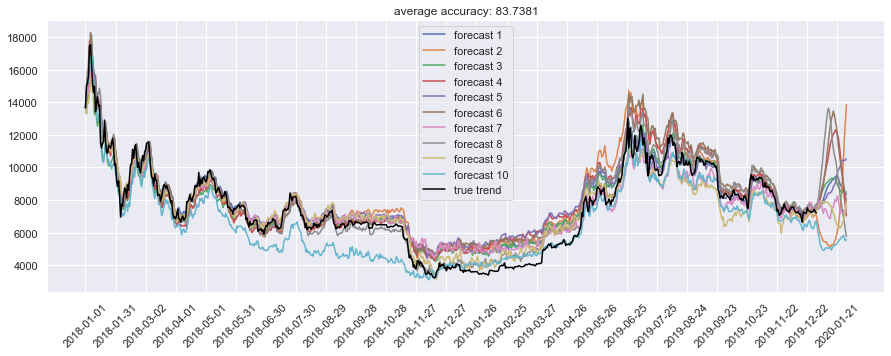

In [96]:
accuracies = [calculate_accuracy(df['close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::30], date_ori[::30], rotation = 45)
plt.show()

In [122]:
a = date_ori[-5:]

In [126]:
type(a)

list

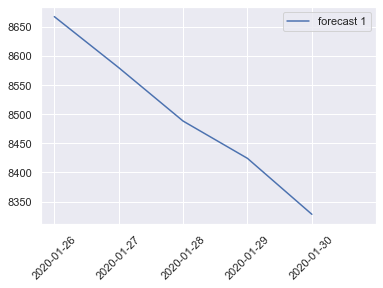

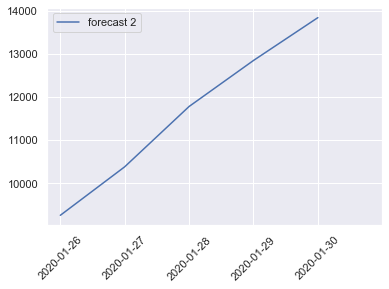

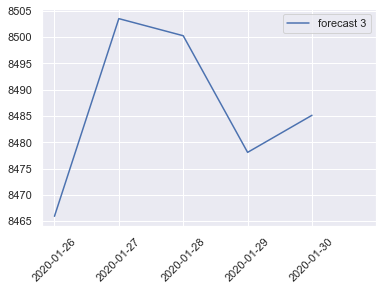

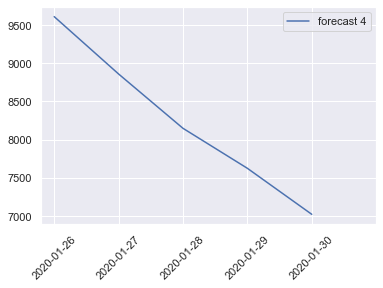

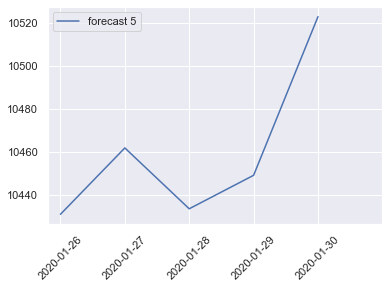

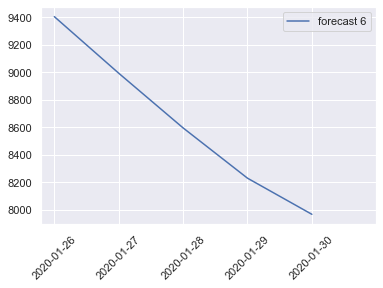

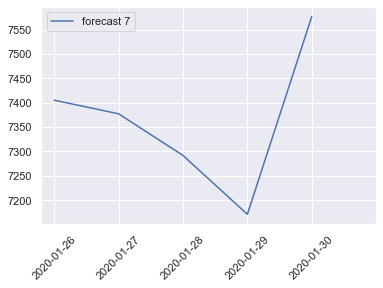

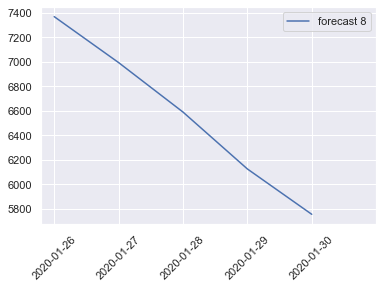

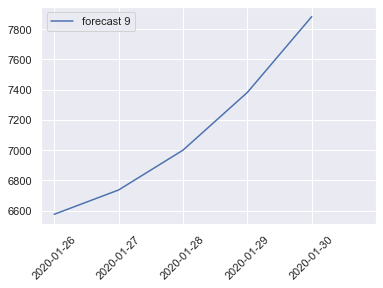

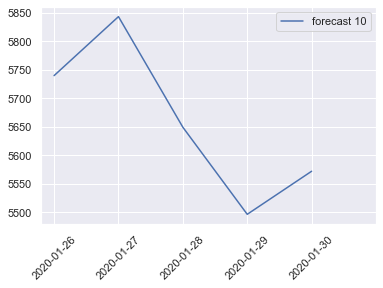

In [138]:
for no, r in enumerate(accepted_results):
    plt.plot(accepted_results[no][-5:], label = 'forecast %d'%(no + 1))
    plt.legend()
    plt.xticks([0,1,2,3,4,5],a, rotation = 45)
    plt.show()